# Table of Contents
 <p>

In [4]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

import sys,os,glob

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
import datetime as dt
from plotMaps import *
from slicingAndSubsetting import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [26]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [6]:
example_time_strides = ['h','3hr','6hour','12hours','d','3day','6days']
for tstride in example_time_strides:
    print(inHours(tstride),end=' ')

1 3 6 12 24 72 144 

In [43]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'
dates = ('185005010100','185005020000')

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

# varid = 'Q'
# varname = 'spechum'

varid='PRECT'
varname='pr'

for tstride in example_time_strides:
    coarse_varname = "%s_%s"%(varname,tstride)
    setattr(thismodule,coarse_varname,getValues(varid,compset,subset,experiment,tstride,dates=dates))
    var = getattr(thismodule,coarse_varname)
    if var is not None:
        print(var.shape) 


Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
(24, 32, 144)
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
(8, 32, 144)
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
(4, 32, 144)
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
(2, 32, 144)
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
(1, 32, 144)
Time stride 3day is too large for the historical files available
Time stride 3day not accessible from processed files
Time stride 6days is too large for the historical files available
Time stride 6days not accessible from processed files


In [8]:
print("Missing files on the scratch directory for %s:"%q_varid)
print()
processed_files = getProcessedFiles(q_varid,inputdir_processed_day)
processed_dates = [f.split('.')[0].split('_')[-1] for f in processed_files]
for d1,d2 in zip(processed_dates[:-1],processed_dates[1:]):
    delta = dt.datetime(int(d2[:4]),int(d2[4:6]),int(d2[6:8]))-dt.datetime(int(d1[:4]),int(d1[4:6]),int(d1[6:8]))
    if delta.days > 1:
        print(delta.days-1,"missing file(s):",d1,'|',d2)

Missing files on the scratch directory for Q:



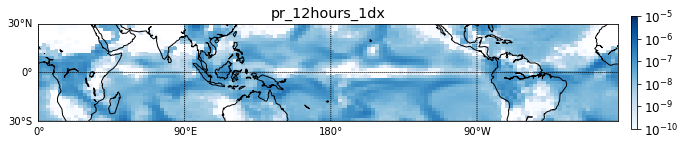

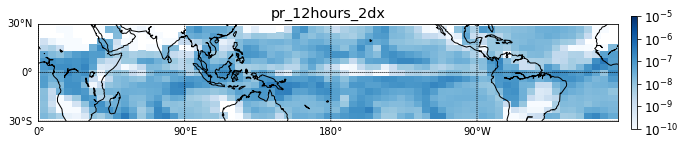

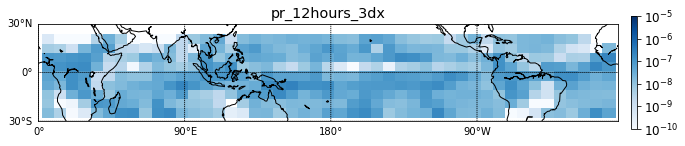

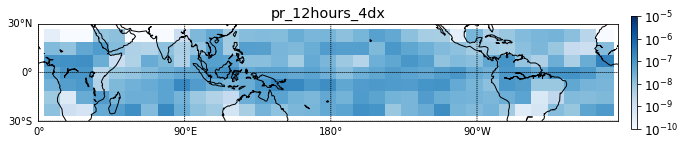

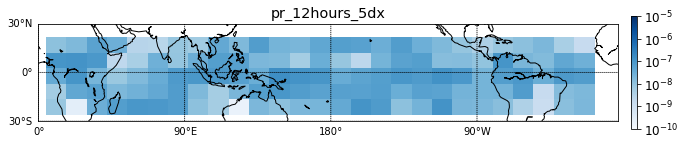

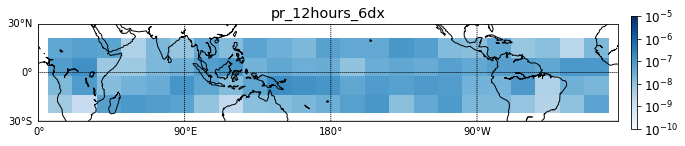

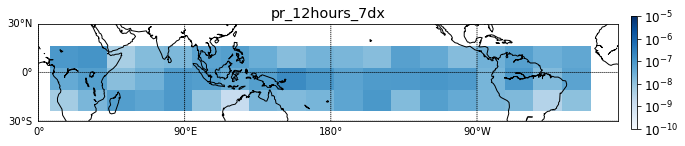

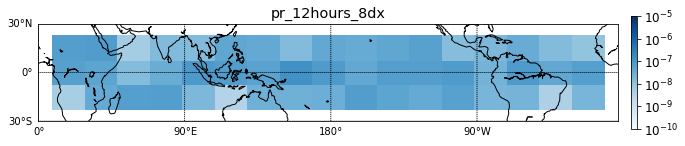

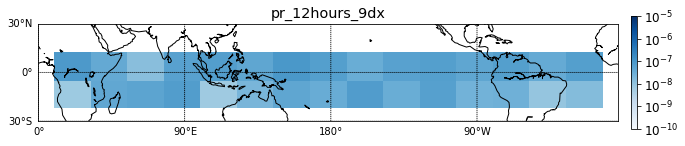

In [77]:
print("-- testing out function coarsenLatLon")

varname = 'pr_12hours'
var = getattr(thismodule,varname)
for n in range(1,10):
    
    coarse_varname = '%s_%ddx'%(varname,n)
    coarse_lonname = 'lon2D_%ddx'%(n)
    coarse_latname = 'lat2D_%ddx'%(n)
    
    setattr(thismodule,coarse_varname,coarsenLatLon(var,n))
    setattr(thismodule,coarse_latname,coarsenLatLon(lat2D,n))
    setattr(thismodule,coarse_lonname,coarsenLatLon(lon2D,n))
    
    coarse_var = getattr(thismodule,coarse_varname)
    coarse_lat = getattr(thismodule,coarse_latname)
    coarse_lon = getattr(thismodule,coarse_lonname)

    plotMapTropics(coarse_lon.compute(),coarse_lat.compute(),coarse_var[0,...].compute(),
                   v_min=1e-10,v_max=1e-5,mode='log',title=coarse_varname,plotfunction='pcolormesh')
    plt.show()